## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [3]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [4]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(sys)

Combined100


In [5]:
parameter_names_1  = set(list(np.array(parameter_names).ravel()))
for p in parameter_names_1:
    print(p)

amplitude
index
lambda_


In [6]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.31 s, sys: 261 ms, total: 6.58 s
Wall time: 6.6 s


## Datasets

In [7]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if "Eff_area" in sys:
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 20
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000
    
    
if "Combined" in sys:
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000

    
if sys == "BKG":
        
    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 10,
                        index1 = 2,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
    frozen_pos = 1
    if frozen_pos:
        dataset_asimov.models.parameters['lon_0'].frozen = True
        dataset_asimov.models.parameters['lat_0'].frozen = True
        dataset_asimov_N.models.parameters['lon_0'].frozen = True
        dataset_asimov_N.models.parameters['lat_0'].frozen = True



## Scan

In [8]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models)
    
    results = []
    for parname1 in parameter_names_1 :
        #if parname1 == 'lambda_':
        print("scanning",  parname1)
        dataset.models.parameters[parname1].scan_n_values=numpoints
        result = fit_cor.stat_profile(dataset,
                             dataset.models.parameters[parname1],
                            reoptimize = True
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "fit_results":
                contour_write[k] = [float(_) for _ in result[k]]#.tolist()
        print(contour_write)
        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        try:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        except:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        results.append(contour)
    return results


In [9]:
%%time
numpoints = 20
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 23.7 ms, sys: 2.47 ms, total: 26.2 ms
Wall time: 27.8 ms


In [10]:
%%time
computing = 0
numpoints = 20

if computing:
    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True
    
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    try:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    except:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_2000.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
        
print(results_N)

[{'Crablog.spectral.amplitude_scan': [2.66002858385549e-11, 2.7510493226172096e-11, 2.845184604934979e-11, 2.9425410041204705e-11, 3.0432287402061955e-11, 3.147361804728751e-11, 3.2550580897820634e-11, 3.366439521486397e-11, 3.4816321980245756e-11, 3.600766532401338e-11, 3.7239774000878205e-11, 3.851404291717928e-11, 3.983191471009872e-11, 4.119488138091249e-11, 4.260448598412986e-11, 4.406232437442946e-11, 4.5570047013374385e-11, 4.712936083794679e-11, 4.8742031193022597e-11, 5.040988382996882e-11], 'stat_scan': [89290.42513765635, 89289.30650435193, 89288.30137700308, 89287.41067317537, 89286.62986117117, 89285.96053404055, 89285.39792423375, 89284.94311941216, 89284.59175334589, 89284.34400993977, 89284.1968806849, 89284.14853070183, 89284.19461224764, 89284.33428837269, 89284.56372870102, 89284.88214504201, 89285.2861853426, 89285.77407893453, 89286.34372015017, 89286.99178070585]}, {'Crablog.spectral.index_scan': [2.029314741253879, 2.057785081930921, 2.0862554226079633, 2.1147257

In [11]:
import colors as s
s.blue

[0.12156862745098039, 0.47058823529411764, 0.7058823529411765]

<Figure size 640x480 with 0 Axes>

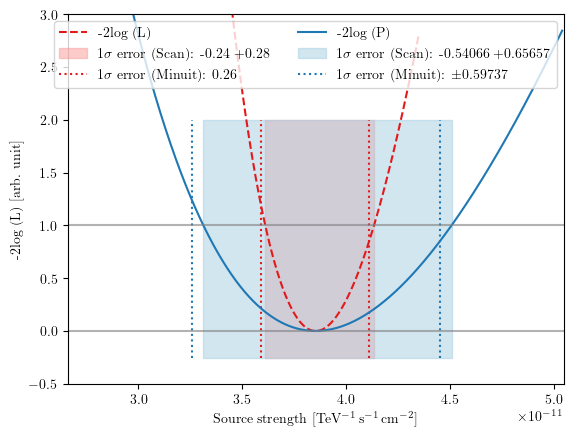

<Figure size 640x480 with 0 Axes>

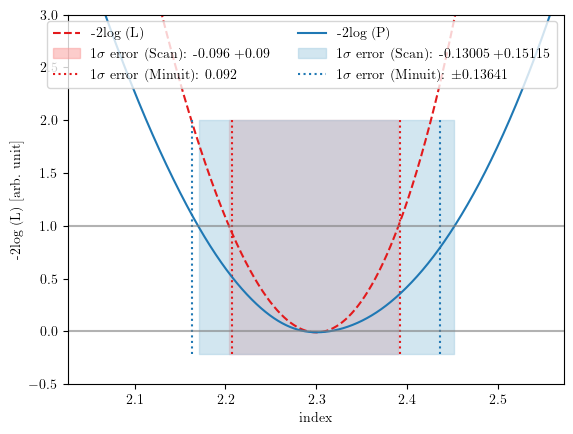

<Figure size 640x480 with 0 Axes>

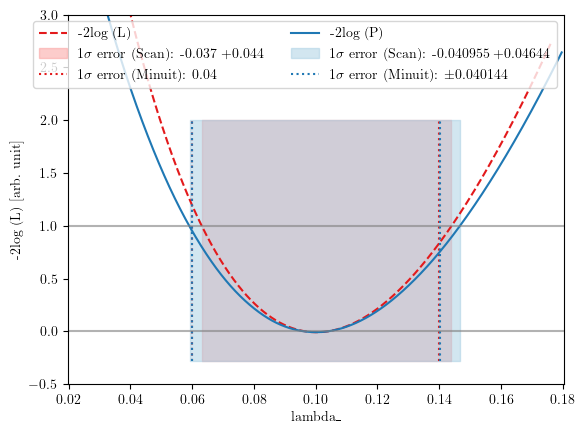

In [12]:
import upper_limit_18_02

colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

colors_ = [awo[0] , aw[0],
           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax, alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.2} +{er_pos*factor:.2} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.2}')

           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.5} +{er_posN*factor:.5} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.5}')
                 
        nn = 2
        ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
                   amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")
    
    

In [13]:
# path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
# dataset_asimov_N.models.write(path, overwrite = 1)

# path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
# dataset_asimov.models.write(path, overwrite = 1)

In [14]:
print(dataset_asimov_N.models.parameters['index'].error)
print(dataset_asimov_N.models.parameters['index'].error_n)
print(dataset_asimov_N.models.parameters['index'].error_p)
print(dataset_asimov_N.models.parameters['index'].value)


0.13640566559612602
0.13004841511663923
0.15115197207731423
2.2991049074129015


In [15]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].value)

0.09232004913014927
0.09572228927707682
0.09007773167842803
2.3


## Minos

In [16]:
lt = c['livetime']

In [31]:
%%time
compute_minos = 0
if compute_minos :
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset_asimov)
    result_cor.minuit.minos()
   

    minos_model = Models(dataset_asimov.models.copy() )
    for p in result_cor.minuit.parameters:
        p_ = p[8:]
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        
        minos_model.parameters[p_].error_n = fit_cor.minuit.merrors[p].lower* factor
        minos_model.parameters[p_].error_p = fit_cor.minuit.merrors[p].upper* factor
    minos_model.write(f'../{folder}/data/4_minos_error_{lt}.yaml', overwrite = True)


    fit_cor_N = Fit(store_trace=False)
    result_cor_N = fit_cor_N.run(dataset_asimov_N)
    result_cor_N.minuit.minos()

    minos_model_N = Models(dataset_asimov_N.models.copy() )
    for p in result_cor_N.minuit.parameters:
        p_ = p[8:]
        print(p_)
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        minos_model_N.parameters[p_].error_n = fit_cor_N.minuit.merrors[p].lower* factor
        minos_model_N.parameters[p_].error_p = fit_cor_N.minuit.merrors[p].upper* factor
        print(fit_cor_N.minuit.merrors[p].lower* factor)
    minos_model_N.write(f'../{folder}/data/4_minos_error_{lt}_nui.yaml', overwrite = True)
    

    
    
else:
    minos_model_N = Models.read(f'../{folder}/data/4_minos_error_{lt}_nui.yaml')    
    minos_model = Models.read(f'../{folder}/data/4_minos_error_{lt}.yaml')
    
minos_model_N.parameters['lambda_'].error_n *= 0.01
minos_model_N.parameters['lambda_'].error_p *= 0.01

minos_model.parameters['lambda_'].error_n *= 0.1
minos_model.parameters['lambda_'].error_p *= 0.1

minos_model_N.parameters['index'].value = dataset_asimov_N.models.parameters['index'].value
minos_model_N.parameters['lambda_'].value = dataset_asimov_N.models.parameters['lambda_'].value
minos_model_N.parameters['amplitude'].value = dataset_asimov_N.models.parameters['amplitude'].value





CPU times: user 51.5 ms, sys: 1.56 ms, total: 53 ms
Wall time: 53.9 ms


In [28]:
print(minos_model.parameters['index'].error)
print(minos_model.parameters['index'].error_n)
print(minos_model.parameters['index'].error_p)
print(minos_model.parameters['index'].value)


0.08819014770564673
-0.09571183623337011
0.09000986905902103
2.302611479892848


In [29]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].value)


0.09232004913014927
0.09572228927707682
0.09007773167842803
2.3


In [22]:
dataset_asimov_N.models.parameters['index'].error_n

0.13004841511663923

amplitude
3.850469705769485e-11
3.853037074270024e-11
index
2.302611479892848
2.2991049074129015
lambda_
0.10003402980250667
0.0999684383542445


<Figure size 640x480 with 0 Axes>

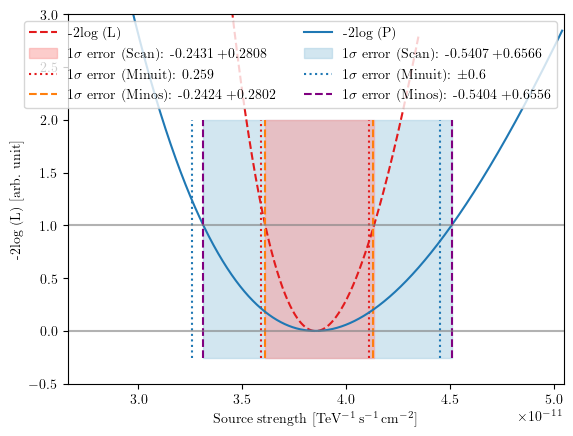

<Figure size 640x480 with 0 Axes>

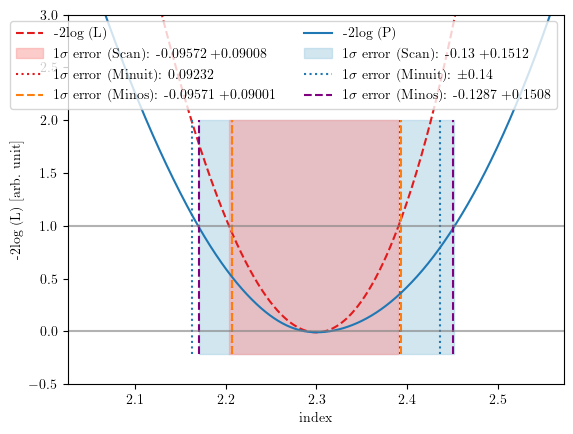

<Figure size 640x480 with 0 Axes>

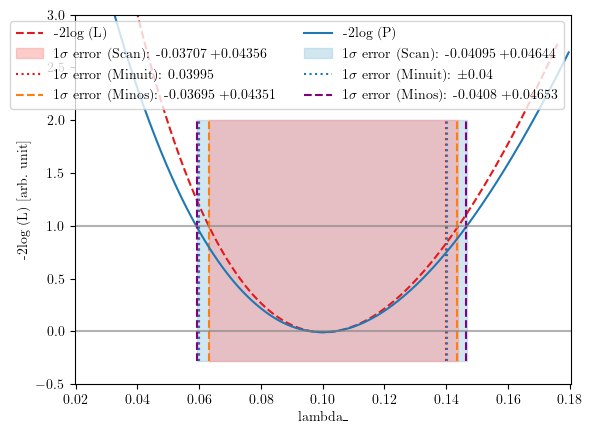

In [32]:
import upper_limit_18_02

colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

colors_ = [awo[0] , aw[0],
           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        print(p)
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [np.nan, np.nan], ylim[0], ymax,  alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.4} +{er_pos*factor:.4} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.4}')
         ## minos 
        # without nui      
        par = minos_model.parameters[p]
        value, error_n, error_p  = par.value, par.error_n, par.error_p
        print(value)
        
        ax.vlines(value+error_n, ylim[0], ymax,color = 'tab:orange' ,
                  linestyles='dashed'
                 )
        ax.vlines(value+error_p, ylim[0], ymax,color = 'tab:orange',
                  linestyles='dashed',
                    label = f'1$\sigma$ error (Minos): {error_n*factor:.4} +{error_p*factor:.4} ')
        
           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.4} +{er_posN*factor:.4} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.2}')
        ## minos 
        # with nui
        par = minos_model_N.parameters[p]
        value, error_n, error_p  = par.value, par.error_n, par.error_p
        print(value)
        ax.vlines(value+error_n, ylim[0], ymax,color = 'purple' ,
                  linestyles='dashed'
                 )
        ax.vlines(value+error_p, ylim[0], ymax,color = 'purple',
                  linestyles='dashed',
                    label = f'1$\sigma$ error (Minos): {error_n*factor:.4} +{error_p*factor:.4} ')
                   
              
            
        nn = 2
        ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
                   amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax,  alpha = 0.5, color=colors_[2],
                        label = f'')
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}_minos.pdf")
    
    

## Minos Errors

In [24]:
unit = "[10^{-11}/\\text{cm}^2 \\text{s} \\text{TeV}] "
unit2 = "[\\text{TeV}^{-1}]"
print(f"& &  $\Phi _0  {unit} $  & $\Lambda$ & $\lambda {unit2}$ \\\ \hline \hline")

for i, m in enumerate([setup.dataset_helper.models[0],minos_model , minos_model_N]):
    if i == 0:
        str_  = f" & Input &" 
    if i == 1:
        str_  = f" Bias  &Without fitting &" 
        
    if i == 2:
        str_  = f" & With fitting  &" 
    for j, p in enumerate(['amplitude', 'index', 'lambda_']):
        factor = 1
        if p == 'amplitude':
            factor = 1e11
            
        if i == 0:
            str_  += f" ${ m.parameters[p].value*factor:.5} $  &" 
        if i > 0:
            str_  += " \error {" + f"{m.parameters[p].value*factor:.5}" + '} { ' + f'{m.parameters[p].error*factor:.3}' + '}  {' + f'{m.parameters[p].error_p*factor:.3}' + '}  {' + f'{m.parameters[p].error_n*factor:.3}' +"} &" 
            
    str_ = str_[:-1]
    str_ += "\\\  "
    str_ += "\hline"
    print(f"{str_}")
    str_ = ""
    print()

& &  $\Phi _0  [10^{-11}/\text{cm}^2 \text{s} \text{TeV}]  $  & $\Lambda$ & $\lambda [\text{TeV}^{-1}]$ \\ \hline \hline
 & Input & $3.85 $  & $2.3 $  & $0.1 $  \\  \hline

 Bias  &Without fitting & \error {3.8505} { 0.25}  {0.28}  {-0.242} & \error {2.3026} { 0.0882}  {0.09}  {-0.0957} & \error {0.10003} { 0.038}  {0.435}  {-0.369} \\  \hline

 & With fitting  & \error {3.853} { 0.596}  {0.656}  {-0.54} & \error {2.2991} { 0.136}  {0.151}  {-0.129} & \error {0.099968} { 0.0401}  {4.65}  {-4.08} \\  \hline



## Scan Errors

In [25]:
unit = "[10^{-11}/\\text{cm}^2 \\text{s} \\text{TeV}] "
unit2 = "[\\text{TeV}^{-1}]"
print(f"& &  $\Phi _0  {unit} $  & $\Lambda$ & $\lambda {unit2}$ \\\ \hline \hline")

for i, m in enumerate([setup.dataset_helper.models[0],dataset_asimov.models[0] , 
                       dataset_asimov_N.models[0]]):
    if i == 0:
        str_  = f" & Input &" 
    if i == 1:
        str_  = f" Bias  &Without fitting &" 
        
    if i == 2:
        str_  = f" & With fitting  &" 
    for j, p in enumerate(['amplitude', 'index', 'lambda_']):
        factor = 1
        if p == 'amplitude':
            factor = 1e11
            
        if i == 0:
            str_  += f" ${ m.parameters[p].value*factor:.5} $  &" 
        if i > 0:
            str_  += " \error {" + f"{m.parameters[p].value*factor:.5}" + '} { ' + f'{m.parameters[p].error*factor:.3}' + '}  {' + f'{m.parameters[p].error_p*factor:.3}' + '}  {' + f'{m.parameters[p].error_n*factor:.3}' +"} &" 
            
    str_ = str_[:-1]
    str_ += "\\\  "
    str_ += "\hline"
    print(f"{str_}")
    str_ = ""
    print()

& &  $\Phi _0  [10^{-11}/\text{cm}^2 \text{s} \text{TeV}]  $  & $\Lambda$ & $\lambda [\text{TeV}^{-1}]$ \\ \hline \hline
 & Input & $3.85 $  & $2.3 $  & $0.1 $  \\  \hline

 Bias  &Without fitting & \error {3.85} { 0.259}  {0.281}  {0.243} & \error {2.3} { 0.0923}  {0.0901}  {0.0957} & \error {0.1} { 0.0399}  {0.0436}  {0.0371} \\  \hline

 & With fitting  & \error {3.853} { 0.597}  {0.657}  {0.541} & \error {2.2991} { 0.136}  {0.151}  {0.13} & \error {0.099968} { 0.0401}  {0.0464}  {0.041} \\  \hline

